In [1]:
# Tensorflow imports
# from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
sns.set(rc={'figure.figsize':(18, 4)})

### Connect to mongo database

In [3]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.internal

In [7]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop(['_id', 'window'], 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df['price_diff'] = df['price'].diff(1)
df['price_lag'] = df['price'].shift(-1)
df = df.dropna()
df = df[df['price_diff'].abs() < 40]
df = df[df['n_tweets'] >= 190]
df = df.iloc[3:-3]

print(df.shape)
df.head()

(1122, 5)


,n_tweets,price,sentiment,price_diff,price_lag
timestamp,,,,,
2019-11-03 15:20:00,247,9201.658,0.134234,-7.814,9201.928
2019-11-03 15:25:00,255,9201.928,0.166929,0.270,9215.040
2019-11-03 15:30:00,213,9215.040,0.141006,13.112,9212.718
2019-11-03 15:35:00,226,9212.718,0.175018,-2.322,9205.842
2019-11-03 15:40:00,205,9205.842,0.159602,-6.876,9194.786


### Function to create timeline plot

In [8]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

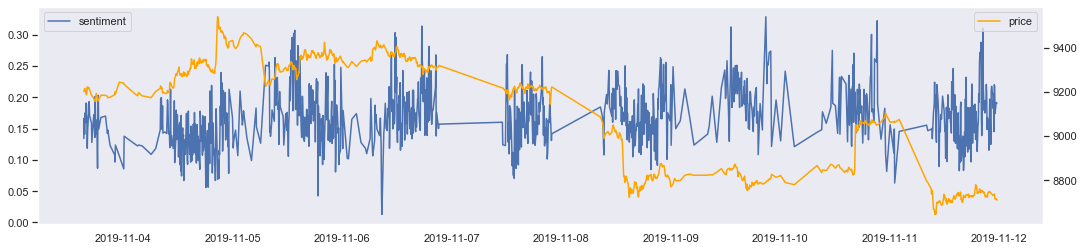

In [9]:
plot_timeline('sentiment', 'price')

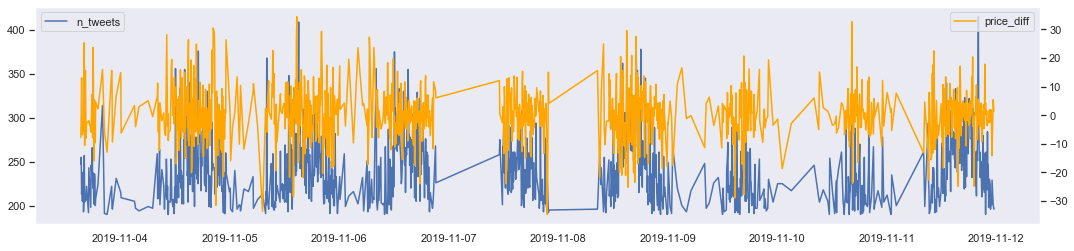

In [10]:
plot_timeline('n_tweets', 'price_diff')

### Prepare training data

In [11]:
df['price'].head()

timestamp
2019-11-03 15:20:00    9201.658
2019-11-03 15:25:00    9201.928
2019-11-03 15:30:00    9215.040
2019-11-03 15:35:00    9212.718
2019-11-03 15:40:00    9205.842
Name: price, dtype: float64

In [14]:
np.set_printoptions(suppress=True)

In [28]:
def split_sequence(sequence, n_steps):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

def generate_train_test(n_steps=12, train_size=.75, flatten=True):
    train_size = int(train_size * len(df))
    
    prices = df['price'].values
    prices_train, prices_test = prices[:train_size], prices[train_size:]
    
    price_diff = df['price_diff'].values
    price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]
    
    sentiment = df['sentiment'].values
    sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]
    
    n_tweets = df['n_tweets'].values
    n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]
    
    train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
    test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)
    
    # Scale the data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    scaler_mean = scaler.mean_
    scaler_var = scaler.var_
    
    # Create the sequence
    X_train = split_sequence(train_scaled, n_steps)
    X_test = split_sequence(test_scaled, n_steps)
    
    y_prices = df['price_lag']

    y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
    y_test = y_prices.iloc[-len(X_test):].values
    
    # Flatten the timeseries
    if flatten:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2], order='F')
        X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2], order='F')
        
    return X_train, X_test, y_train, y_test, (scaler_mean, scaler_var)

In [48]:
X_train, X_test, y_train, y_test, scaler_values = generate_train_test(n_steps=4, flatten=True)
X_train.shape

(837, 12)

In [49]:
X_train[:3,:3]

array([[0.01803452, 0.01931215, 0.08135729],
       [0.01931215, 0.08135729, 0.07036974],
       [0.08135729, 0.07036974, 0.03783294]])

In [50]:
y_train[:3]

array([9194.786, 9186.642, 9196.86 ])

In [51]:
scaler_values[0], np.sqrt(scaler_values[1])

(array([9197.84676397,    0.16698417,  241.01189061]),
 array([211.32999473,   0.04467786,  36.76013908]))

### Build the keras model

In [23]:
# model.add(BatchNormalization())
# model.add(Dropout(.65))
# model.add(Dense(41, activation='relu'))
# model.add(LSTM(32, activation='relu'))
# model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))

In [65]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_lstm_model():
    model = Sequential()
    
    model.add(LSTM(32, activation='relu', input_shape=(3, 4)))
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss=root_mean_squared_error)
    
    return model

def build_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
    
    model.add(Dense(32, activation='relu', 
#                     kernel_regularizer=regularizers.l2(0.01)
                   ))
        
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    
    return model

In [66]:
# Create the model
model = build_model()
model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=32)

# Checkpoints
checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)

# Fit the model
model.fit(
    X_train, 
    y_train, 
    validation_split=0.33,
    epochs=256, 
    batch_size=64,
    callbacks=[checkpointer, early_stopping]);

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 32)                416       
_________________________________________________________________
dense_53 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 33        
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
Train on 560 samples, validate on 277 samples
Epoch 1/256
 64/560 [==>...........................] - ETA: 2s - loss: 9329.1953
Epoch 00001: val_loss improved from inf to 8948.09861, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 616us/sample - loss: 9321.1667 - val_loss: 8948.0986
Epoch 2/256
 64/560 [==>...........................] - ETA: 0s - 

Epoch 28/256
 64/560 [==>...........................] - ETA: 0s - loss: 9110.5391
Epoch 00028: val_loss improved from 8903.61705 to 8899.04846, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 92us/sample - loss: 9109.9007 - val_loss: 8899.0485
Epoch 29/256
 64/560 [==>...........................] - ETA: 0s - loss: 9091.0957
Epoch 00029: val_loss improved from 8899.04846 to 8894.17057, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 97us/sample - loss: 9083.8228 - val_loss: 8894.1706
Epoch 30/256
 64/560 [==>...........................] - ETA: 0s - loss: 9085.2070
Epoch 00030: val_loss improved from 8894.17057 to 8888.98110, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 102us/sample - loss: 9055.7781 - val_loss: 8888.9811
Epoch 31/256
 64/560 [==>...........................] - ETA: 0s - loss: 9044.1904
Epoch 00031: val_loss improved from 8888.98110 to 8883.45592, saving model to keras_we

560/560 [==============================] - 0s 84us/sample - loss: 7296.4094 - val_loss: 8595.4724
Epoch 58/256
 64/560 [==>...........................] - ETA: 0s - loss: 7279.0308
Epoch 00058: val_loss improved from 8595.47238 to 8578.05308, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 85us/sample - loss: 7188.8878 - val_loss: 8578.0531
Epoch 59/256
 64/560 [==>...........................] - ETA: 0s - loss: 7056.6660
Epoch 00059: val_loss improved from 8578.05308 to 8560.15100, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 76us/sample - loss: 7078.6600 - val_loss: 8560.1510
Epoch 60/256
 64/560 [==>...........................] - ETA: 0s - loss: 6962.9819
Epoch 00060: val_loss improved from 8560.15100 to 8541.86489, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 74us/sample - loss: 6964.4358 - val_loss: 8541.8649
Epoch 61/256
 64/560 [==>...........................] - ETA: 0s - loss:

 64/560 [==>...........................] - ETA: 0s - loss: 3754.0588
Epoch 00087: val_loss improved from 7918.04024 to 7892.99536, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 97us/sample - loss: 3457.8369 - val_loss: 7892.9954
Epoch 88/256
 64/560 [==>...........................] - ETA: 0s - loss: 3194.6204
Epoch 00088: val_loss improved from 7892.99536 to 7868.41055, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 89us/sample - loss: 3367.2662 - val_loss: 7868.4106
Epoch 89/256
 64/560 [==>...........................] - ETA: 0s - loss: 3289.9983
Epoch 00089: val_loss improved from 7868.41055 to 7844.51524, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 87us/sample - loss: 3288.9408 - val_loss: 7844.5152
Epoch 90/256
 64/560 [==>...........................] - ETA: 0s - loss: 3297.4441
Epoch 00090: val_loss improved from 7844.51524 to 7820.90154, saving model to keras_weights.hdf5
560

560/560 [==============================] - 0s 108us/sample - loss: 2571.7212 - val_loss: 7449.7964
Epoch 117/256
 64/560 [==>...........................] - ETA: 0s - loss: 2891.6721
Epoch 00117: val_loss improved from 7449.79639 to 7439.03636, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 149us/sample - loss: 2561.6532 - val_loss: 7439.0364
Epoch 118/256
 64/560 [==>...........................] - ETA: 0s - loss: 2557.5701
Epoch 00118: val_loss improved from 7439.03636 to 7428.79367, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 105us/sample - loss: 2569.1113 - val_loss: 7428.7937
Epoch 119/256
 64/560 [==>...........................] - ETA: 0s - loss: 2733.6833
Epoch 00119: val_loss improved from 7428.79367 to 7418.69588, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 96us/sample - loss: 2548.8700 - val_loss: 7418.6959
Epoch 120/256
 64/560 [==>...........................] - ETA: 0s 

 64/560 [==>...........................] - ETA: 0s - loss: 2211.9893
Epoch 00146: val_loss improved from 7163.24811 to 7151.88774, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 95us/sample - loss: 2381.3710 - val_loss: 7151.8877
Epoch 147/256
 64/560 [==>...........................] - ETA: 0s - loss: 2242.8943
Epoch 00147: val_loss improved from 7151.88774 to 7141.51030, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 104us/sample - loss: 2374.1838 - val_loss: 7141.5103
Epoch 148/256
 64/560 [==>...........................] - ETA: 0s - loss: 2485.1311
Epoch 00148: val_loss improved from 7141.51030 to 7131.90537, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 99us/sample - loss: 2373.8899 - val_loss: 7131.9054
Epoch 149/256
 64/560 [==>...........................] - ETA: 0s - loss: 2426.4619
Epoch 00149: val_loss improved from 7131.90537 to 7122.26897, saving model to keras_weights.hdf5

560/560 [==============================] - 0s 101us/sample - loss: 2211.4136 - val_loss: 6828.0984
Epoch 176/256
 64/560 [==>...........................] - ETA: 0s - loss: 2247.9126
Epoch 00176: val_loss improved from 6828.09843 to 6815.78841, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 101us/sample - loss: 2213.7820 - val_loss: 6815.7884
Epoch 177/256
 64/560 [==>...........................] - ETA: 0s - loss: 2291.1653
Epoch 00177: val_loss improved from 6815.78841 to 6803.91305, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 101us/sample - loss: 2197.3995 - val_loss: 6803.9131
Epoch 178/256
 64/560 [==>...........................] - ETA: 0s - loss: 2271.8547
Epoch 00178: val_loss improved from 6803.91305 to 6791.67140, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 86us/sample - loss: 2200.4841 - val_loss: 6791.6714
Epoch 179/256
 64/560 [==>...........................] - ETA: 0s 

 64/560 [==>...........................] - ETA: 0s - loss: 1835.9871
Epoch 00205: val_loss improved from 6453.94448 to 6440.44379, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 87us/sample - loss: 2037.5853 - val_loss: 6440.4438
Epoch 206/256
 64/560 [==>...........................] - ETA: 0s - loss: 2118.8936
Epoch 00206: val_loss improved from 6440.44379 to 6426.16039, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 105us/sample - loss: 2033.9926 - val_loss: 6426.1604
Epoch 207/256
 64/560 [==>...........................] - ETA: 0s - loss: 1924.4775
Epoch 00207: val_loss improved from 6426.16039 to 6410.67321, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 102us/sample - loss: 2027.2845 - val_loss: 6410.6732
Epoch 208/256
 64/560 [==>...........................] - ETA: 0s - loss: 1713.9631
Epoch 00208: val_loss improved from 6410.67321 to 6397.31586, saving model to keras_weights.hdf

560/560 [==============================] - 0s 95us/sample - loss: 1840.7374 - val_loss: 5989.2423
Epoch 235/256
 64/560 [==>...........................] - ETA: 0s - loss: 1698.0372
Epoch 00235: val_loss improved from 5989.24227 to 5970.47390, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 88us/sample - loss: 1844.2403 - val_loss: 5970.4739
Epoch 236/256
 64/560 [==>...........................] - ETA: 0s - loss: 1939.2749
Epoch 00236: val_loss improved from 5970.47390 to 5953.88113, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 85us/sample - loss: 1841.1336 - val_loss: 5953.8811
Epoch 237/256
 64/560 [==>...........................] - ETA: 0s - loss: 1689.9385
Epoch 00237: val_loss improved from 5953.88113 to 5934.64341, saving model to keras_weights.hdf5
560/560 [==============================] - 0s 75us/sample - loss: 1833.8914 - val_loss: 5934.6434
Epoch 238/256
 64/560 [==>...........................] - ETA: 0s - l

### Load model

In [67]:
def load_trained_model():
    model = build_model()
    model.load_weights('keras_weights.hdf5')
    
    return model

model = load_trained_model()

#### Baseline functions
* Roll - always predict previous price
* Zero - always predict zero

In [68]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [69]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [70]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $24.97
Test baseline zero: $8808.71
Test RMSE: $6695.21


In [71]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $15.82
Train baseline zero: $9200.33
Train RMSE: $3576.73


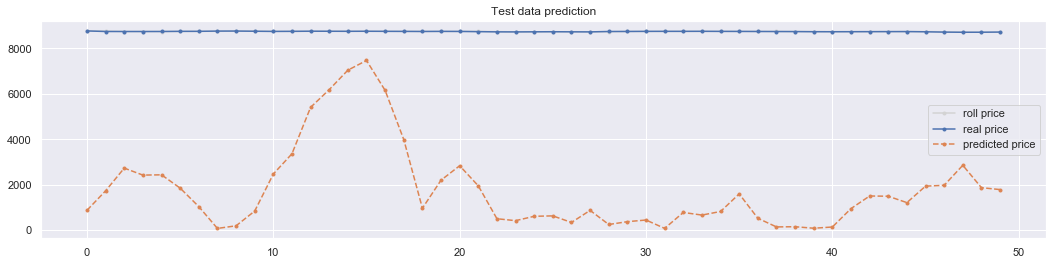

In [72]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

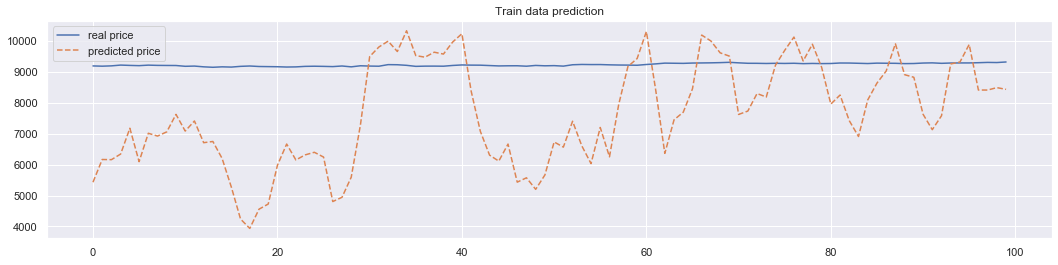

In [73]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

## Hyperopt

In [74]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def build_model(dense_layers=2, dense_hidden_size=8, dropout_rate=0, l1_reg=0, l2_reg=0, 
                optimizer_function='adam', learning_rate=0.001, **arg):
    model = Sequential()
    model.add(Dense(dense_hidden_size, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    
    for layer in range(dense_layers-1):
        model.add(Dense(dense_hidden_size, activation='relu', 
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer_function, loss=root_mean_squared_error)
    
    return model    

In [108]:
space = {'dense_layers': hp.choice('dense_layers', [1, 2, 3]),
         
         'dense_hidden_size': hp.choice('dense_hidden_size', [8,16,32,64]),
         
         'regularization': hp.choice('regularization', 
                                     [{'reg_type': 'dropout',
                                       'dropout_rate': hp.choice('dropout_rate', [0.20, 0.35, 0.50])},
                                       {'reg_type': 'l1', 
                                        'l1_reg': hp.loguniform('l1_reg', -9, -2)}, 
                                       {'reg_type': 'l2', 
                                        'l2_reg': hp.loguniform('l2_reg', -9, -2)}]),
         
         'optimizer_function': hp.choice('optimizer_function', ['adam', 'RMSprop'])}

In [109]:
def hyperopt_wrapper(params):
#     print('Params testing: ', params)
    
    model = build_model(**params)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=32)
    
    checkpointer = ModelCheckpoint(filepath='hyperopt_weights.hdf5',
                                   verbose=0,
                                   save_best_only=True)
    
    result = model.fit(X_train, 
                        y_train, 
                        verbose=0,
                        validation_split=0.33,
                        epochs=256, 
                        batch_size=64,
                        callbacks=[checkpointer, early_stopping])
    
    loss = np.amin(result.history['val_loss'])
    
    print('Loss: {0:.2f}'.format(loss))
    return {'loss': loss, 'status': STATUS_OK, 'trained_model': model}  

In [110]:
trials = Trials()
best = fmin(hyperopt_wrapper, 
            space, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials)

Best validation loss of epoch:                      
257.3533224939009                                   
Best validation loss of epoch:                                              
6827.9023578519855                                                          
Best validation loss of epoch:                                              
254.841473520878                                                            
Best validation loss of epoch:                                              
267.4575913632389                                                          
Best validation loss of epoch:                                             
8813.097511704647                                                          
Best validation loss of epoch:                                             
8809.399724306182                                                          
Best validation loss of epoch:                                             
8920.713997630866                                    

In [111]:
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['trained_model']

In [112]:
config = best_model.get_config()

In [113]:
model = Sequential.from_config(config)
model.compile(optimizer='adam', loss=root_mean_squared_error)

In [114]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 32)                416       
_________________________________________________________________
dropout_83 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_84 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_85 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 1)               

In [116]:
early_stopping = EarlyStopping(monitor='loss', patience=64)

checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                               verbose=0,
                               save_best_only=True)

result = model.fit(X_train, 
                   y_train, 
#                    verbose=0,
                   epochs=512, 
                   batch_size=32,
                   callbacks=[checkpointer, early_stopping])

Train on 837 samples
Epoch 1/512
837/837 [==============================] - 0s 41us/sample - loss: 23.6064
Epoch 2/512
837/837 [==============================] - 0s 40us/sample - loss: 22.4341
Epoch 3/512
837/837 [==============================] - 0s 47us/sample - loss: 22.9670
Epoch 4/512
837/837 [==============================] - 0s 85us/sample - loss: 22.1891
Epoch 5/512
837/837 [==============================] - 0s 73us/sample - loss: 22.8638
Epoch 6/512
837/837 [==============================] - 0s 65us/sample - loss: 22.4301
Epoch 7/512
837/837 [==============================] - 0s 53us/sample - loss: 22.5869
Epoch 8/512
837/837 [==============================] - 0s 66us/sample - loss: 23.9793
Epoch 9/512
837/837 [==============================] - 0s 61us/sample - loss: 22.0217
Epoch 10/512
837/837 [==============================] - 0s 54us/sample - loss: 22.1986
Epoch 11/512
837/837 [==============================] - 0s 54us/sample - loss: 21.9110
Epoch 12/512
837/837 [=========

837/837 [==============================] - 0s 54us/sample - loss: 21.6276
Epoch 96/512
837/837 [==============================] - 0s 50us/sample - loss: 21.2726
Epoch 97/512
837/837 [==============================] - 0s 54us/sample - loss: 22.6397
Epoch 98/512
837/837 [==============================] - 0s 55us/sample - loss: 24.5939
Epoch 99/512
837/837 [==============================] - 0s 50us/sample - loss: 22.6850
Epoch 100/512
837/837 [==============================] - 0s 48us/sample - loss: 23.2444
Epoch 101/512
837/837 [==============================] - 0s 50us/sample - loss: 21.7358
Epoch 102/512
837/837 [==============================] - 0s 49us/sample - loss: 22.8643
Epoch 103/512
837/837 [==============================] - 0s 52us/sample - loss: 22.2864
Epoch 104/512
837/837 [==============================] - 0s 45us/sample - loss: 23.1426
Epoch 105/512
837/837 [==============================] - 0s 93us/sample - loss: 23.0055
Epoch 106/512
837/837 [===========================

In [117]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 2)[2:], data[2:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [118]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [119]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.45
Test baseline zero: $8808.71
Test RMSE: $72.61


In [120]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $23.66
Train baseline zero: $9200.33
Train RMSE: $23.24


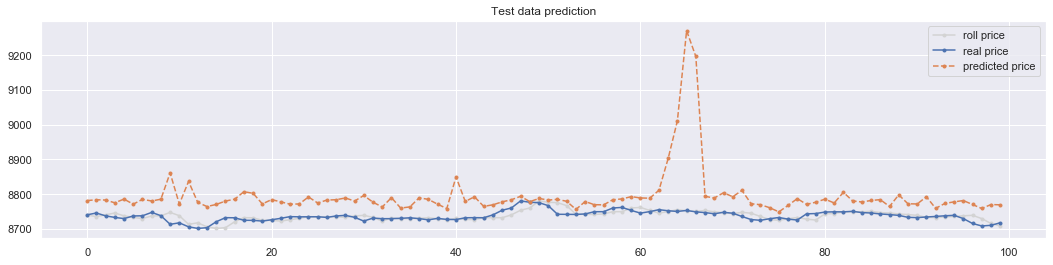

In [122]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 2)[-100:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-100:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-100:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

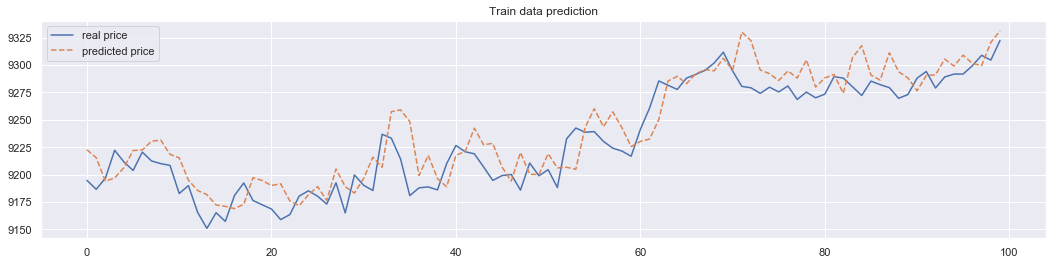

In [123]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

### XGBoost

In [307]:
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

In [281]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'objective':        'reg:squarederror',
    'n_estimators':     10000
}

xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_data_params = {
    'n_steps': hp.choice('n_steps', np.arange(1, 24, 1, dtype=int)),
}

xgb_parameters = dict()
xgb_parameters['reg_params']  = xgb_reg_params
xgb_parameters['fit_params']  = xgb_fit_params
xgb_parameters['data_params'] = xgb_data_params

In [282]:
class Hyperopt():
    
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            print({'status': STATUS_FAIL, 'exception': str(e)})
        else:
            return result, trials

    def xgb_regression(self, parameters):
        model = XGBRegressor(**parameters['reg_params'])
        return self.train(model, parameters)

    def train(self, model, parameters):
        X_train, X_test, y_train, y_test = generate_train_test(**parameters['data_params'])
        
        model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                **parameters['fit_params'])
        
        y_hat = model.predict(X_test)
        loss = np.sqrt(mean_squared_error(y_test, y_hat))
        
        return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [308]:
optimizer = Hyperopt()

best, trails = optimizer.process(
    fn_name='xgb_regression', 
    space=xgb_parameters, 
    trials=Trials(), 
    algo=rand.suggest,
    max_evals=20)

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  2.88s/it, best loss: 38.095362672543025]


In [309]:
def get_best_model(trails):
    best_idx = np.argmin([trail['result']['loss'] for trail in trails])
    return list(trails)[best_idx]['result']['model']

def get_best_data_params(parameters, best_params):
    return space_eval(parameters, best_params)['data_params']

In [310]:
data_params = get_best_data_params(xgb_parameters, best)

X_train, X_test, y_train, y_test = generate_train_test(**data_params)

In [311]:
xgboost = get_best_model(trails)

In [312]:
# Predict using the test data
y_hat = xgboost.predict(X_test)
y_hat_train = xgboost.predict(X_train)

In [313]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $34.88
Test baseline zero: $5327.72
Test RMSE: $38.10


In [314]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $116.47
Train baseline zero: $8599.96
Train RMSE: $76.55


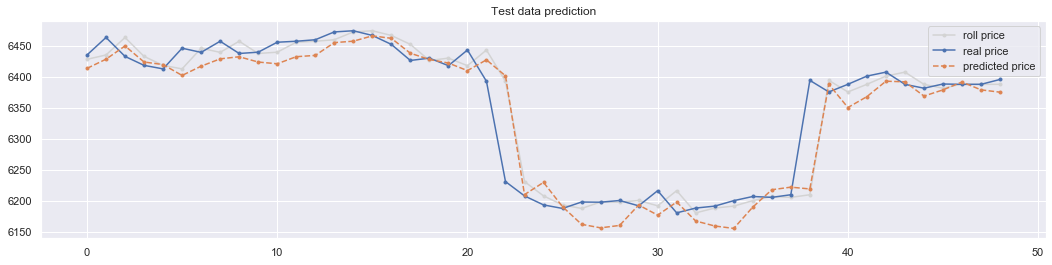

In [315]:
plt.plot(np.roll(y_test, 1)[1:50], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[1:50], label='real price', marker='o', markersize=3)
plt.plot(y_hat[1:50], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

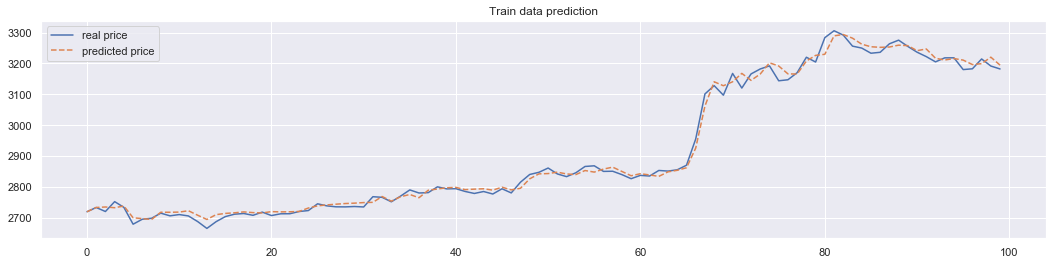

In [316]:
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();